# Feature selection using Logistic regression

Logistic regression is not just another statistical technique; it's a fundamental building block of machine learning and a go-to method for tackling binary classification problems. Its ability to predict outcomes in the form of probabilities makes it indispensable in a wide range of fields, from healthcare and finance to social sciences and beyond. With its simplicity, interpretability, and robustness, logistic regression has earned its place as a must-know tool for data scientists, analysts, and decision-makers.

Feature selection is akin to mining for precious gems in a vast quarry. In this article, we embark on a quest to unearth those gems and explore three fundamental techniques that can enhance the predictive power of logistic regression—a workhorse of classification and binary decision-making tasks.

## Representation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from patsy import dmatrices
#from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
class LogisticRegression:
    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.coefficients = None
        
   

    def fit(self, X, y, single_feature= False):
        n_samples, n_features = X.shape 

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # gradient descent
        for _ in range(self.n_iters):
            # approximate y with linear combination of weights and x, plus bias
            linear_model = np.dot(X, self.weights) + self.bias
            # apply sigmoid function
            y_predicted = self._sigmoid(linear_model)

            # compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            # update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
        self.coefficients = regression_solver(X, y)

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
def regression_solver(X, y):
    # Add a column of ones to X for the bias term
    X = np.hstack((np.ones((X.shape[0], 1)), X))

    # Use the normal equations to calculate the coefficients
    XtX = np.dot(X.T, X)
    XtX_inv = np.linalg.inv(XtX)
    Xty = np.dot(X.T, y)
    coefficients = np.dot(XtX_inv, Xty)

    # The first element is the bias term, and the rest are feature coefficients
    return coefficients   


In [3]:
def accuracy_score(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
all_df = pd.read_csv(url, sep=";")
all_df['quality'] = all_df['quality']

X_df = all_df.drop('quality', axis=1)
y_df = all_df['quality'].apply(lambda x: 1 if x > 5 else 0)

In [5]:
X_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [6]:
X_df.shape

(1599, 11)

In [7]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
dtypes: float64(11)
memory usage: 137.5 KB


In [8]:
col_names = X_df.columns
col_names

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [9]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.3, random_state=1, stratify=y_df)
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_df, y_train_df, test_size=0.2, random_state=3, stratify=y_train_df)

In [10]:
y_train_df

238     1
1041    1
221     0
857     1
431     0
       ..
1584    1
375     1
109     0
1514    1
116     1
Name: quality, Length: 895, dtype: int64

In [54]:
scaler = StandardScaler()
Xs_train_df = pd.DataFrame(scaler.fit_transform(X_train_df))
Xs_test_df = pd.DataFrame(scaler.transform(X_test_df))
Xs_val_df = pd.DataFrame(scaler.transform(X_val_df))

In [55]:
Xs_train_df.columns = col_names
Xs_test_df.columns = col_names
Xs_val_df.columns = col_names


# Feature importance

Imagine having a treasure map that guides you to the most valuable artifacts. Feature importance, as one of our guiding stars, helps identify the features that carry the most weight in making predictions. By understanding which attributes have the greatest impact, we can streamline our models, reduce complexity, and achieve superior results.

In [13]:
LR = LogisticRegression()
LR.fit(Xs_train_df, y_train_df)

In [14]:
predict = LR.predict(Xs_test_df)
predict

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,

In [15]:
Xs_train_df.shape

(895, 11)

In [16]:
Xs_test_df.shape

(480, 11)

In [17]:
feature_importance = LR.coefficients[1:]
feature_importance

array([ 0.05685858, -0.100884  , -0.02942406,  0.00991547, -0.04194257,
        0.0321496 , -0.10132233, -0.03840215,  0.00086036,  0.10771086,
        0.14726758])

In [18]:
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_idx

array([10,  9,  0,  5,  3,  8,  2,  7,  4,  1,  6])

In [19]:
feature_importance = feature_importance[sorted_idx]
feature_importance

array([ 0.14726758,  0.10771086,  0.05685858,  0.0321496 ,  0.00991547,
        0.00086036, -0.02942406, -0.03840215, -0.04194257, -0.100884  ,
       -0.10132233])

In [20]:
feature_names= X_df.columns
feature_names = [feature_names[i] for i in sorted_idx]
feature_names

['alcohol',
 'sulphates',
 'fixed acidity',
 'free sulfur dioxide',
 'residual sugar',
 'pH',
 'citric acid',
 'density',
 'chlorides',
 'volatile acidity',
 'total sulfur dioxide']

In [21]:
def plot_feature_importance(X, y, feature_names=None):
    """
    Compute and plot feature importance using Logistic Regression coefficients.
    
    Parameters:
    - X: Input feature matrix (numpy array or pandas DataFrame).
    - y: Target variable (numpy array or pandas Series).
    - feature_names: List of feature names (optional).
    
    Returns:
    - feature_importance: Array of feature importances (absolute coefficients).
    """
    model = LogisticRegression()
    model.fit(X, y)
    
    # Take the absolute values of coefficients, excluding the bias
    feature_importance = np.abs(model.coefficients[1:]) 
    
    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(X.shape[1])]
    
    # Sort feature importance in descending order
    sorted_idx = np.argsort(feature_importance)[::-1]
    feature_importance = feature_importance[sorted_idx]
    feature_names = [feature_names[i] for i in sorted_idx]
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importance)),feature_importance, align='center')
    plt.yticks(range(len(feature_importance)), feature_names)
    plt.ylabel('Feature')
    plt.xlabel('Feature Importance (Absolute Coefficient)')
    plt.title('Feature Importance (Logistic Regression)')
    plt.show()
    
    return feature_importance

# Example usage:
# Assuming you have X (feature matrix) and y (target variable)
# feature_importance = plot_feature_importance_logistic_regression(X, y, feature_names=X.columns)


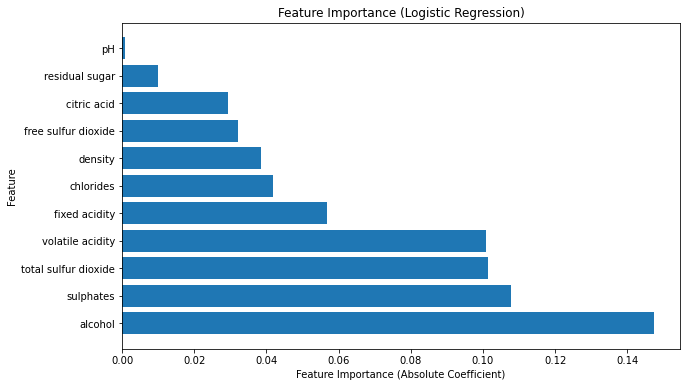

In [22]:
feature_importance = plot_feature_importance(Xs_train_df, y_train_df, col_names)

# Correlation feature selection

Just as certain gems complement each other's shine, some features exhibit strong interrelationships. However, redundant or highly correlated features can introduce noise and confusion. We'll delve into the art of scrutinizing feature relationships, pruning away redundancies, and ensuring that our models focus on distinct, non-overlapping information.

<AxesSubplot:>

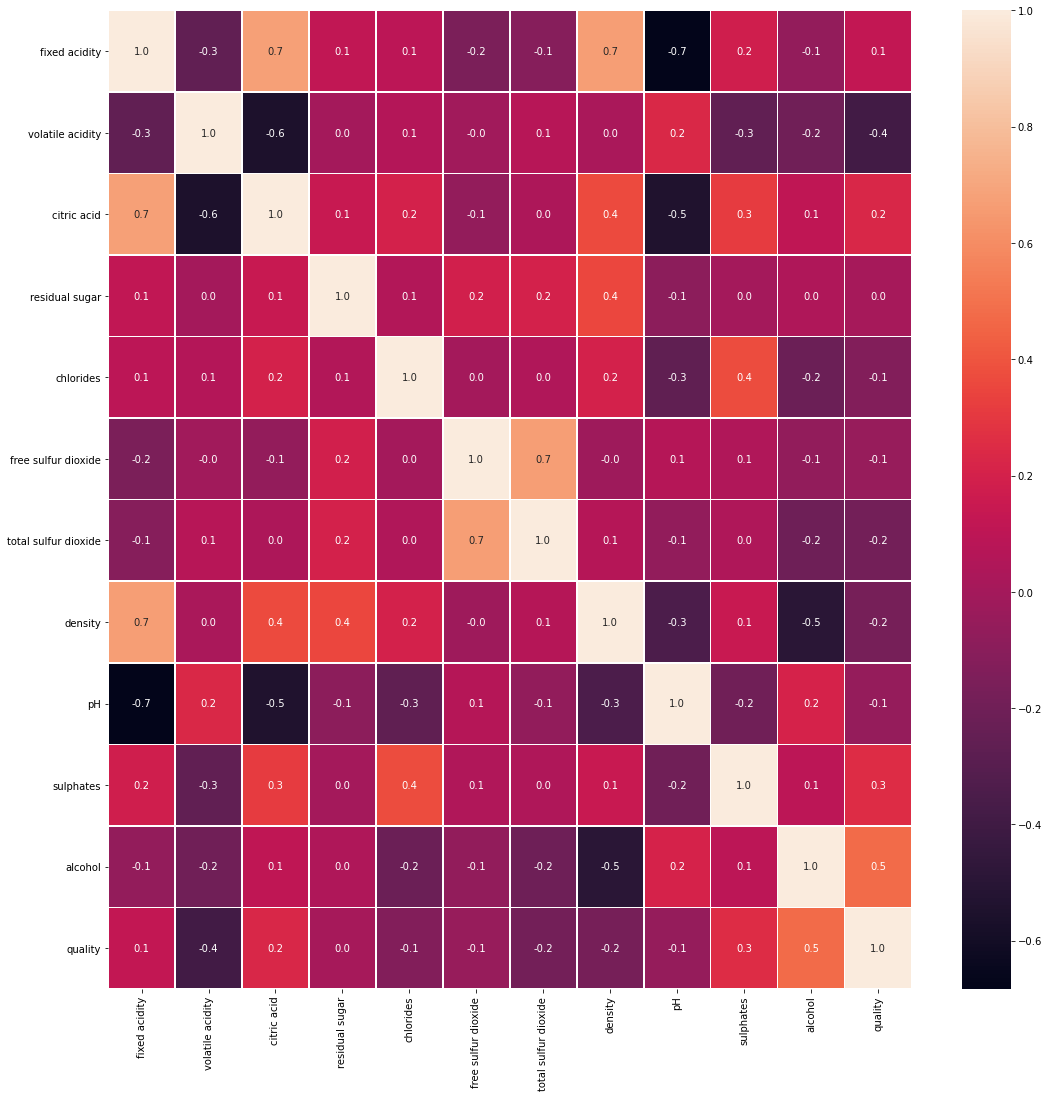

In [23]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(all_df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [24]:
correlation_matrix = all_df.corr()

target_correlation = correlation_matrix["quality"].drop("quality")

sorted_target_correlation = target_correlation.abs().sort_values(ascending=False)

sorted_target_correlation

alcohol                 0.476166
volatile acidity        0.390558
sulphates               0.251397
citric acid             0.226373
total sulfur dioxide    0.185100
density                 0.174919
chlorides               0.128907
fixed acidity           0.124052
pH                      0.057731
free sulfur dioxide     0.050656
residual sugar          0.013732
Name: quality, dtype: float64

In [25]:
# Splitting the data into features and target variable
#X = wine_data.drop('quality', axis=1)
#y = wine_data['quality']

In [26]:
def cross_validation(X, y, model, k=5):
    """
    Perform k-fold cross-validation for a given model.

    Parameters:
        X (numpy.ndarray): Feature matrix.
        y (numpy.ndarray): Target vector.
        model: Your custom logistic regression model.
        k (int): Number of folds for cross-validation.

    Returns:
        List of accuracy scores for each fold.
    """
    n = len(X)
    fold_size = n // k
    accuracy_scores = []

    for i in range(k):
        # Split data into training and validation sets
        start, end = i * fold_size, (i + 1) * fold_size
        X_train = pd.concat([X.iloc[:start], X.iloc[end:]], axis=0)
        y_train = pd.concat([y.iloc[:start], y.iloc[end:]], axis=0)
        X_val, y_val = X.iloc[start:end], y.iloc[start:end]
        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the validation data
        y_pred = model.predict(X_val)

        # Calculate accuracy and store it
        accuracy = accuracy_score(y_val, y_pred)
        accuracy_scores.append(accuracy)

    return accuracy_scores

In [27]:
#LR2=LogisticRegression()

In [28]:
# Define a range of thresholds
thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3]
accuracies = []

# For each threshold, select features and evaluate model performance using cross-validation
for threshold in thresholds:
    selected = sorted_target_correlation[sorted_target_correlation.abs() > threshold].index.tolist()
    X_threshold = Xs_train_df[selected]
    # Normalize the data
    #X_threshold_scaled = scaler.fit_transform(X_threshold)
    # Using cross-validation to get accuracy
    accuracy = cross_validation(X_threshold, y_train_df, LR, k=5)
    accuracies.append(np.average(accuracy))

In [29]:
y_train_df

238     1
1041    1
221     0
857     1
431     0
       ..
1584    1
375     1
109     0
1514    1
116     1
Name: quality, Length: 895, dtype: int64

In [30]:
np.average(accuracy)

0.7329608938547485

In [31]:
accuracies

[0.7385474860335195,
 0.7363128491620111,
 0.7363128491620111,
 0.7363128491620111,
 0.7363128491620111,
 0.741899441340782,
 0.741899441340782,
 0.741899441340782,
 0.741899441340782,
 0.741899441340782,
 0.741899441340782,
 0.7385474860335195,
 0.7385474860335195,
 0.7307262569832402,
 0.7273743016759776,
 0.7508379888268156,
 0.7329608938547485]

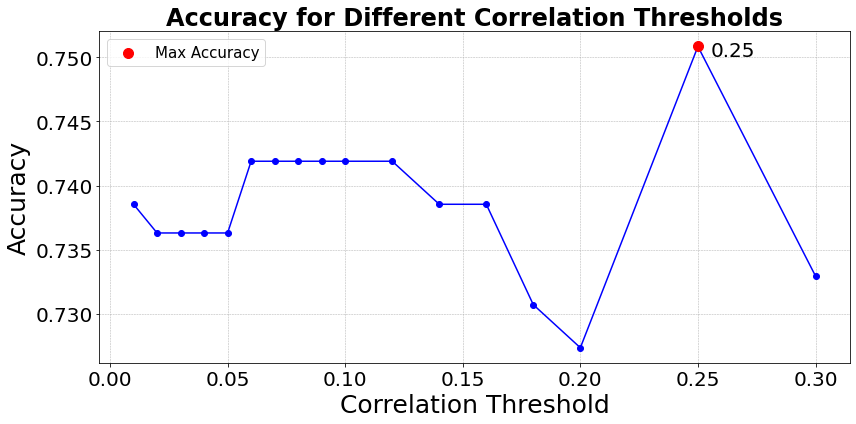

In [32]:
max_accuracy = max(accuracies)
max_index = accuracies.index(max_accuracy)
max_threshold = thresholds[max_index]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(thresholds, accuracies, marker='o', linestyle='-', color='b')

# Highlight the point with the highest accuracy
plt.scatter(max_threshold, max_accuracy, color='r', s=100, zorder=5, label='Max Accuracy')

# Annotate the highlighted point with its accuracy value
plt.annotate(f'{max_threshold:.2f}', (max_threshold, max_accuracy), textcoords="offset points", xytext=(35,-10), ha='center', fontsize=20)

# Setting the title, x and y labels with specified font sizes and weights
plt.title('Accuracy for Different Correlation Thresholds', fontweight='bold', fontsize=24)
plt.xlabel('Correlation Threshold', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [33]:
# Adjusting the threshold for selecting features based on their correlation with the target to 0.08
corr_selected_features = sorted_target_correlation[sorted_target_correlation.abs() > 0.30].index.tolist()

# Removing features that are highly correlated with each other
for feature in corr_selected_features:
    if feature not in sorted_target_correlation.index:
        continue  # The feature was already removed due to high correlation with another feature
    high_corr_features = correlation_matrix[feature][corr_selected_features].drop(feature)
    redundant_features = high_corr_features[high_corr_features.abs() > 0.8].index.tolist()
    for redundant_feature in redundant_features:
        if sorted_target_correlation[feature] > sorted_target_correlation[redundant_feature]:
            corr_selected_features.remove(redundant_feature)
        else:
            corr_selected_features.remove(feature)
            break  # Exit inner loop if the feature was removed

corr_selected_features

['alcohol', 'volatile acidity']

# Backward selection

Sometimes, the best path forward is to retrace your steps. In the context of logistic regression, backward selection is our compass for navigating through a forest of features. We start with all available attributes and iteratively remove those that contribute little to the model's performance. This iterative refinement process enables us to sculpt our models into lean, efficient instruments of prediction.

In [37]:
def backward_selection(X, y, model, stopping_criterion=0.01):
    """
    Backward feature selection and return selected features.
    
    Parameters:
    - X: Input feature matrix (numpy array or pandas DataFrame).
    - y: Target variable (numpy array or pandas Series).
    - model: Machine learning model with a fit and predict method.
    - stopping_criterion: The tolerance for feature removal. The process stops when accuracy drops below this threshold.
    
    Returns:
    - selected_features: List of selected feature indices.
    """
    num_features = X.shape[1]
    selected_attributes = list(range(num_features))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    base_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    while len(selected_attributes) > 1:
        max_accuracy = -1
        feature_to_remove = None

        for feature_index in selected_attributes:
            reduced_features = selected_attributes.copy()
            reduced_features.remove(feature_index)
            print(reduced_features)
            X_train_reduced = X_train.iloc[:, reduced_features]
            X_test_reduced = X_test.iloc[:, reduced_features]
          

            model.fit(X_train_reduced, y_train)
            y_pred = model.predict(X_test_reduced)
            accuracy = accuracy_score(y_test, y_pred)
            print(accuracy)

            if accuracy > max_accuracy:
                max_accuracy = accuracy
                feature_to_remove = feature_index

        if (base_accuracy - max_accuracy) < stopping_criterion:
            break

        selected_attributes.remove(feature_to_remove)
        base_accuracy = max_accuracy

    return selected_attributes



In [38]:
LG_model = LogisticRegression(0.1)
bs_selected_features = backward_selection(Xs_train_df,y_train_df, LG_model, 0.9)
bs_selected_features

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
0.7653631284916201
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10]
0.7430167597765364
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10]
0.770949720670391
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10]
0.7821229050279329
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10]
0.7597765363128491
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10]
0.7821229050279329
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10]
0.7877094972067039
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
0.770949720670391
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10]
0.776536312849162
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]
0.7821229050279329
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
0.7653631284916201


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Optimisation

## Hyperparameter tuning

In [57]:
learning_rates=[0.1,0.01,0.001,0.0001]
def hypTune(X_train, y_train, X_val, y_val):
    scores = []
    for lr in learning_rates:
        logReg = LogisticRegression(lr)
        logReg.fit(X_train, y_train)
        predict = logReg.predict(X_val)
        acc = accuracy_score(y_val, predict)
        scores.append(acc)
    return scores

In [58]:
scores = hypTune(Xs_train_df, y_train_df, X_val_df, y_val_df)
scores

[0.5044642857142857, 0.4955357142857143, 0.46875, 0.4732142857142857]

# Evaluation

In [40]:
final_selection = Xs_train_df[corr_selected_features]
final_selection

,alcohol,volatile acidity
0,-1.329246,0.529889
1,-0.614252,-0.222804
2,-0.971749,-0.007749
3,0.726361,-1.459371
4,-1.150498,0.099778
...,...,...
890,0.994484,-1.136788
891,1.173233,0.046015
892,-1.061124,1.363227
893,-1.120706,1.658928


In [48]:
final_selection_test = Xs_test_df[corr_selected_features]
final_selection_test

,alcohol,volatile acidity
0,-0.822792,1.363227
1,-0.167381,-0.007749
2,-0.524878,0.368597
3,-0.256755,0.261070
4,0.636987,1.873983
...,...,...
475,-0.167381,-0.276568
476,0.279490,-0.061513
477,0.547613,-0.975497
478,-0.971749,0.099778


In [49]:
final_model = LogisticRegression(0.1)
final_model.fit(final_selection, y_train_df)

In [50]:
final_selection_test = Xs_test_df[corr_selected_features]
predict = final_model.predict(final_selection_test)

In [51]:
accuracy = accuracy_score(y_test_df, predict)
accuracy

0.7270833333333333

In [52]:
# We use confusion matrix (TP, TN, FP, FN) to visualise the performance

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test_df, predict)

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       223
           1       0.77      0.70      0.73       257

    accuracy                           0.73       480
   macro avg       0.73      0.73      0.73       480
weighted avg       0.73      0.73      0.73       480



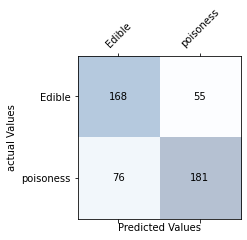

In [53]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
classes=["Edible", "poisoness"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values',)
plt.ylabel('actual Values',);
print(classification_report(y_test_df, predict))